In [141]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from EqMotion import Adjoint, Integrator

In [2]:
def LFR(t):
    return 0.95 - (0.95-0.15) / 80.0 * t

def alpha3(t):
    return 9.8 + (60.0 - 9.8) * t / 150.0

def alpha2(t):
    return np.sin(t * 2 * np.pi / 3.0) * np.tanh(t/150.0)

def alpha2_I(t):
    return np.exp(-(t/2.0)**2)

def theta(t):
    return 0.0

def d2theta(t):
    return 0.0

## **Check the forward and the backward function and eval the gradient**

In [3]:
pRef = np.array([6.0, 20.0, 40.0])
refAdj = Adjoint(nmodes=3, Np = 1)
refAdj.set_omgfunc(pRef)
t = np.linspace(0.0, 10.0, 501)
q, q_func = refAdj.forward(np.zeros(6), t, alpha2_I, alpha3, 0.0, LFR)

In [156]:
solver = Adjoint(nmodes=3,Np=1, t=t, y0=np.zeros(6), 
                 weight = np.array([0, 0.0, 1.0]), corrweight=np.array([0.0, 0.0, 0.0]),
                 alpha2=alpha2_I, alpha3=alpha3, theta=0.0, LFRt=LFR,
                 q=q, q_func=q_func)

In [157]:
p0 = np.array([4.0, 16.0, 34.5])

objVal = solver.eval_obj(p0)
objGrad = solver.eval_grad()
print(objVal)
print(objGrad)

0.00912755703340954
[ 0.         0.        -0.0002621]


Text(0, 0.5, '$F$')

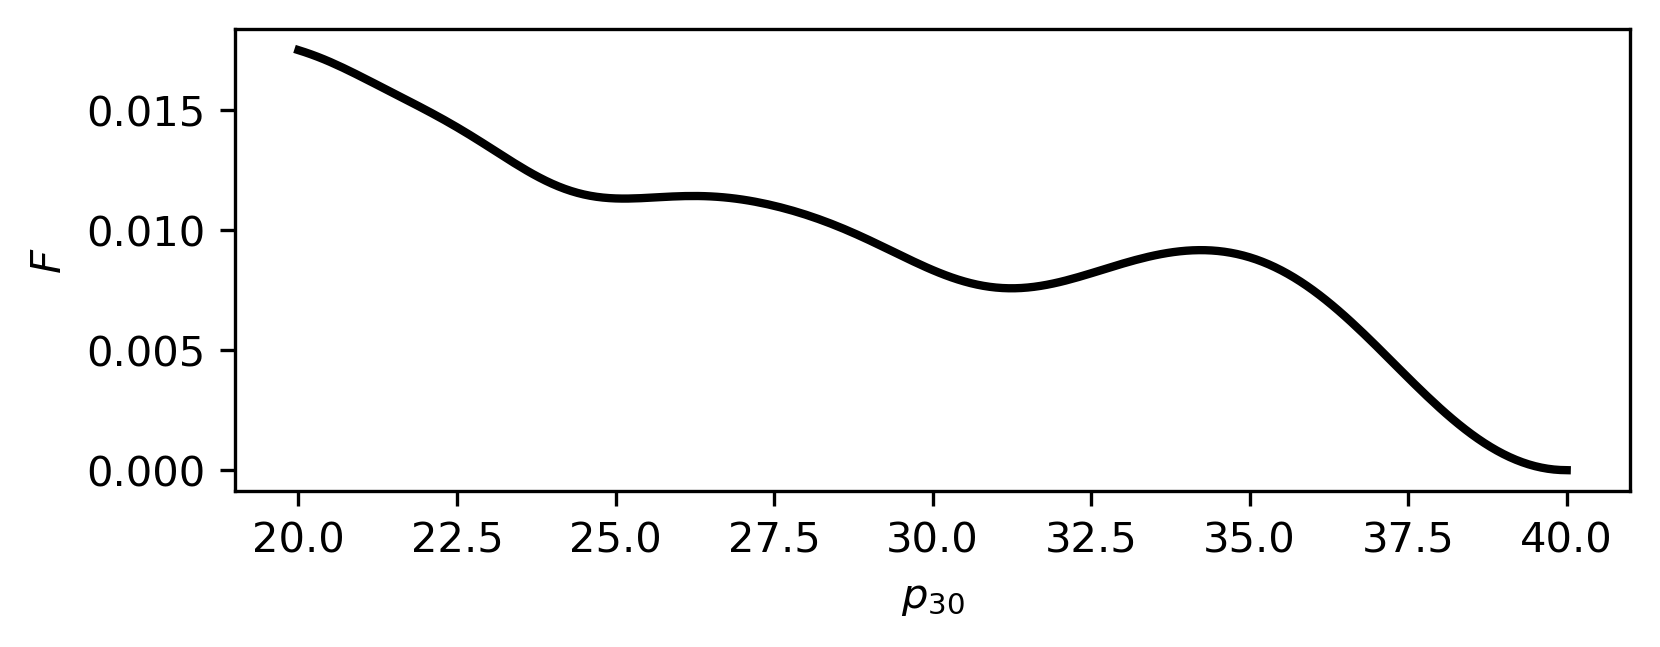

In [162]:
objVals = []
fig = plt.figure(figsize=(6,2), dpi = 300)
p2 = np.linspace(20.0, 40.0, 201)
for pp in p2:
    p = np.array([10.0, 10.0, pp])
    objVals.append(solver.eval_obj(p))

plt.plot(p2, objVals, lw = 2, c = "k")
plt.xlabel(r"$p_{30}$")
plt.ylabel("$F$")

In [137]:
fd_e_2 = []
step = 1e-2
for i in range(3):
    eps = np.zeros(3)
    eps[i] = step
    fd_e_2.append((solver.eval_obj(p0+eps) - objVal) / step)
fd_e_2 = np.array(fd_e_2)
print(fd_e_2)

fd_e_3 = []
step = 1e-3
for i in range(3):
    eps = np.zeros(3)
    eps[i] = step
    fd_e_3.append((solver.eval_obj(p0+eps) - objVal) / step)
fd_e_3 = np.array(fd_e_3)
print(fd_e_3)

fd_e_4 = []
step = 1e-4
for i in range(3):
    eps = np.zeros(3)
    eps[i] = step
    fd_e_4.append((solver.eval_obj(p0+eps) - objVal) / step)
fd_e_4 = np.array(fd_e_4)
print(fd_e_4)

fd_e_5 = []
step = 1e-5
for i in range(3):
    eps = np.zeros(3)
    eps[i] = step
    fd_e_5.append((solver.eval_obj(p0+eps) - objVal) / step)
fd_e_5 = np.array(fd_e_5)
print(fd_e_5)

[-3.93023566e-01 -9.38472625e-04 -2.69171256e-04]
[-3.90594091e-01 -9.02268612e-04 -3.02158700e-04]
[-3.90349137e-01 -8.98657885e-04 -3.06356350e-04]
[-0.39032462 -0.0008983  -0.00069328]


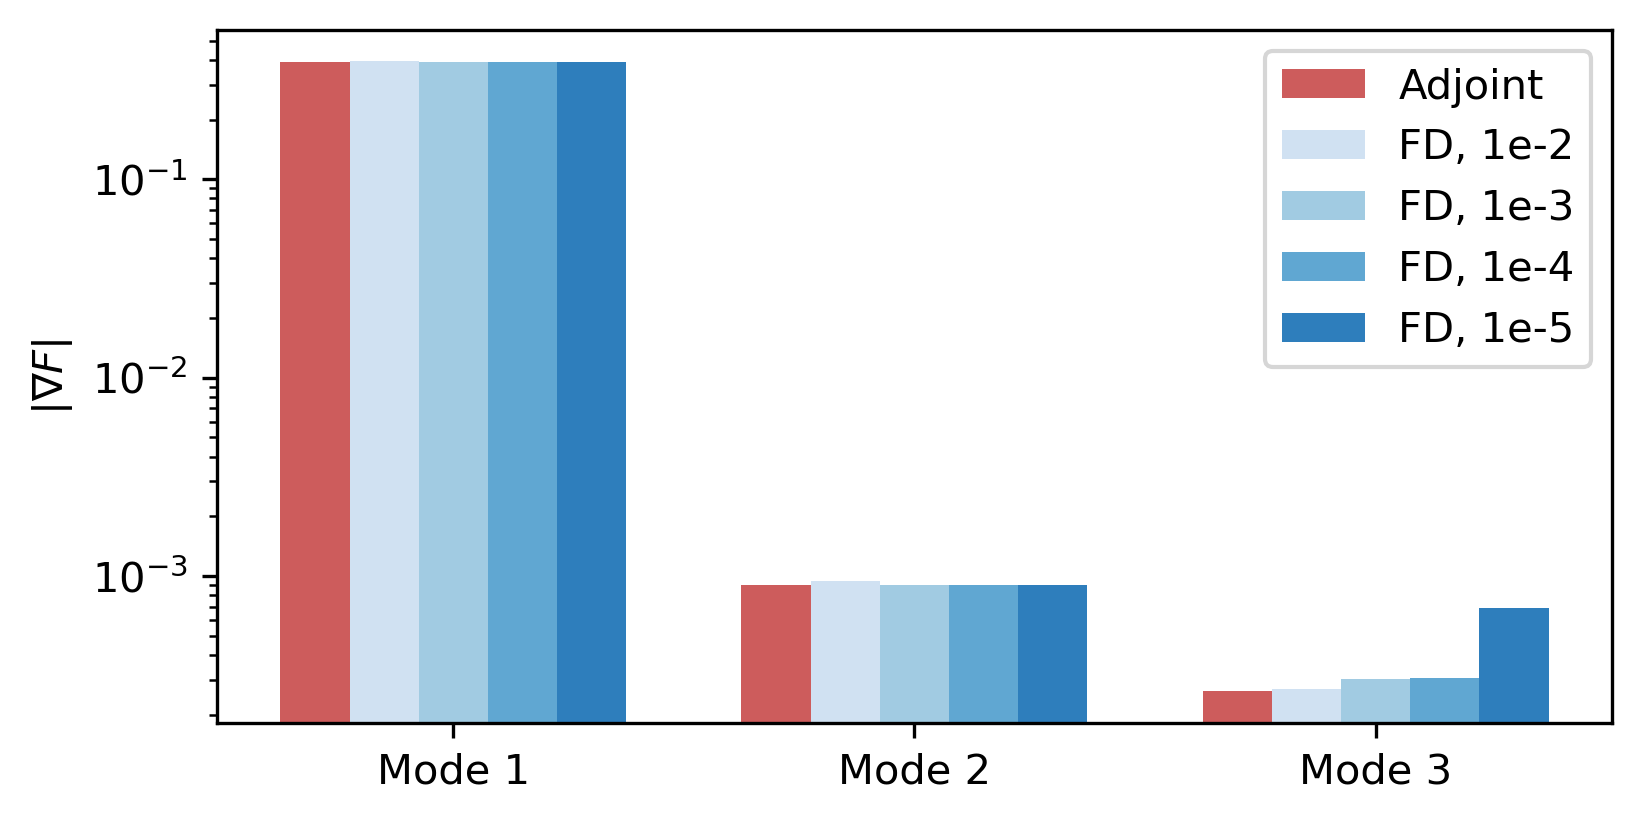

In [155]:
import matplotlib.cm
cmap = matplotlib.colormaps["Blues"]
colors = cmap(np.linspace(0.2, 0.7, 4))
pos = np.array([0.0, 1.0, 2.0])
wid = 0.15

plt.figure(figsize=(6,3), dpi=300)
plt.bar(x=pos,       height=np.abs(objGrad), width=wid, facecolor="indianred",label = "Adjoint")
plt.bar(x=pos+wid,   height=np.abs(fd_e_2),  width=wid, facecolor=colors[0]  ,label = "FD, 1e-2")
plt.bar(x=pos+2*wid, height=np.abs(fd_e_3),  width=wid, facecolor=colors[1]  ,label = "FD, 1e-3")
plt.bar(x=pos+3*wid, height=np.abs(fd_e_4),  width=wid, facecolor=colors[2]  ,label = "FD, 1e-4")
plt.bar(x=pos+4*wid, height=np.abs(fd_e_5),  width=wid, facecolor=colors[3]  ,label = "FD, 1e-5")
plt.yscale("log")

plt.ylabel(r"$|\nabla F|$")
plt.xticks([0.3, 1.3, 2.3], labels=["Mode {:d}".format(k+1) for k in range(3)])
plt.legend()

## **Use gradient descent to optimize the parameters**

In [57]:
from tqdm import tqdm

def gradient_descent(solver, p0, n_iter, alpha = 0.3, beta = 0.8, tol = 1e-6, learning_rate = 1e-3, linesearch=True):
    '''
    Use first order optimization algorithm to find the suitable parameters for the system
    '''
    p = p0
    objVal0 = solver.eval_obj(p)
    p_history = [p0]
    obj_history = [objVal0]

    for _ in tqdm(range(n_iter)):
        t = 1.0
        objVal = solver.eval_obj(p)
        objGrad = solver.eval_grad()

        if linesearch:
            while solver.eval_obj(p - t * objGrad) > objVal - alpha*t*np.dot(objGrad,objGrad):
                t *= beta
        else:
            t = learning_rate

        p_new = p - t * objGrad
        if np.linalg.norm(p_new - p) < tol:
            break
        p = p_new

        p_history.append(p)
        obj_history.append(solver.eval_obj(p))

    return p_history, obj_history

def line_search_WOLFE(solver,p,t,nabla):
    '''
    BACKTRACK LINE SEARCH WITH WOLFE CONDITIONS
    '''
    a = 1
    c1 = 1e-4 
    c2 = 0.9 
    fx = solver.eval_obj(p)
    p_new = p + a * t 
    fx_new = solver.eval_obj(p_new)
    nabla_new = solver.eval_grad()
    while fx_new >= fx + (c1*a*nabla.T@t) or nabla_new.T@t <= c2*nabla.T@t : 
        a *= 0.5
        p_new = p + a * t 
        fx_new = solver.eval_obj(p_new)
        nabla_new = solver.eval_grad()
    return a

def line_search(solver, p, t, objVal, alpha = 0.3, beta = 0.8):
    a = 1.0
    while solver.eval_obj(p + a * t) > objVal - alpha*a*np.dot(t, t):
        a *= beta
    return a

def BFGS(solver, p0, n_iter):
    objVal = solver.eval_obj(p0)
    nabla = solver.eval_grad()
    d = p0.shape[0]
    H = np.eye(d)
    p = p0
    obj_history = [objVal]
    p_history = [p]

    for _ in tqdm(range(n_iter)):
        t = -H@nabla
        # a = line_search_WOLFE(solver,p,t,nabla)
        a = line_search(solver, p, t, objVal)
        s = a * t
        p_new = p + s

        objVal = solver.eval_obj(p_new)
        nabla_new = solver.eval_grad()
        obj_history.append(objVal)
        p_history.append(p_new)

        # Update the Hessian
        y = nabla_new - nabla 
        y = np.array([y])
        s = np.array([s])
        y = np.reshape(y,(d,1))
        s = np.reshape(s,(d,1))
        r = 1/(y.T@s)
        li = (np.eye(d)-(r*((s@(y.T)))))
        ri = (np.eye(d)-(r*((y@(s.T)))))
        hess_inter = li@H@ri
        H = hess_inter + (r*((s@(s.T)))) # BFGS Update
        nabla = nabla_new[:] 
        p = p_new[:]

    return p_history, obj_history


In [9]:
p_history, obj_history = gradient_descent(solver, p0, n_iter = 1000, alpha = 0.3, linesearch=True)

  1%|          | 7/1000 [00:04<11:35,  1.43it/s]


KeyboardInterrupt: 

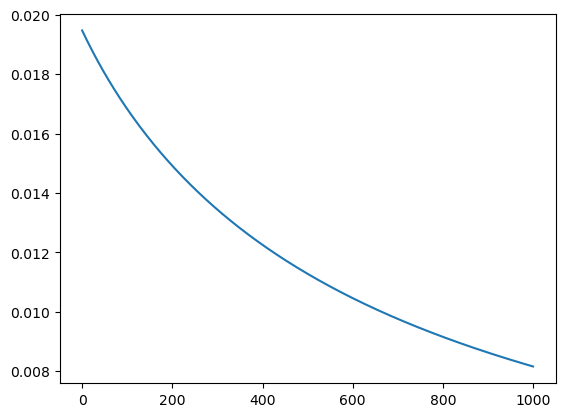

In [43]:
plt.plot(obj_history)

In [44]:
p_history = np.array(p_history)

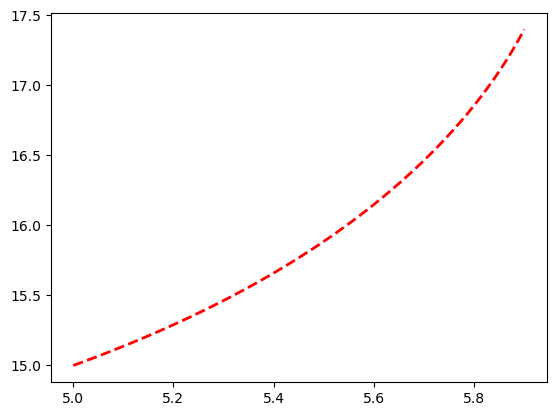

In [45]:
plt.plot(p_history[:, 0], p_history[:, 1], label = "Opt. History", ls = "dashed", lw = 2, c = "r")
# plt.scatter(pRef[0], pRef[1], marker="*")

Now we try to solve the optimization problem using the Scipy built-in 2-nd order methods.

In [116]:
from scipy.optimize import minimize

opt_res = minimize(solver.eval_obj, x0=p0, jac = solver.eval_grad_, tol = 1e-7)
print(opt_res)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.4676148539526614e-15
        x: [ 6.000e+00  2.000e+01  4.000e+01]
      nit: 18
      jac: [ 4.180e-10  1.045e-11 -4.586e-11]
 hess_inv: [[ 1.909e+00  2.307e-01 -1.657e-01]
            [ 2.307e-01  9.320e+01  1.488e+00]
            [-1.657e-01  1.488e+00  7.489e+02]]
     nfev: 39
     njev: 39


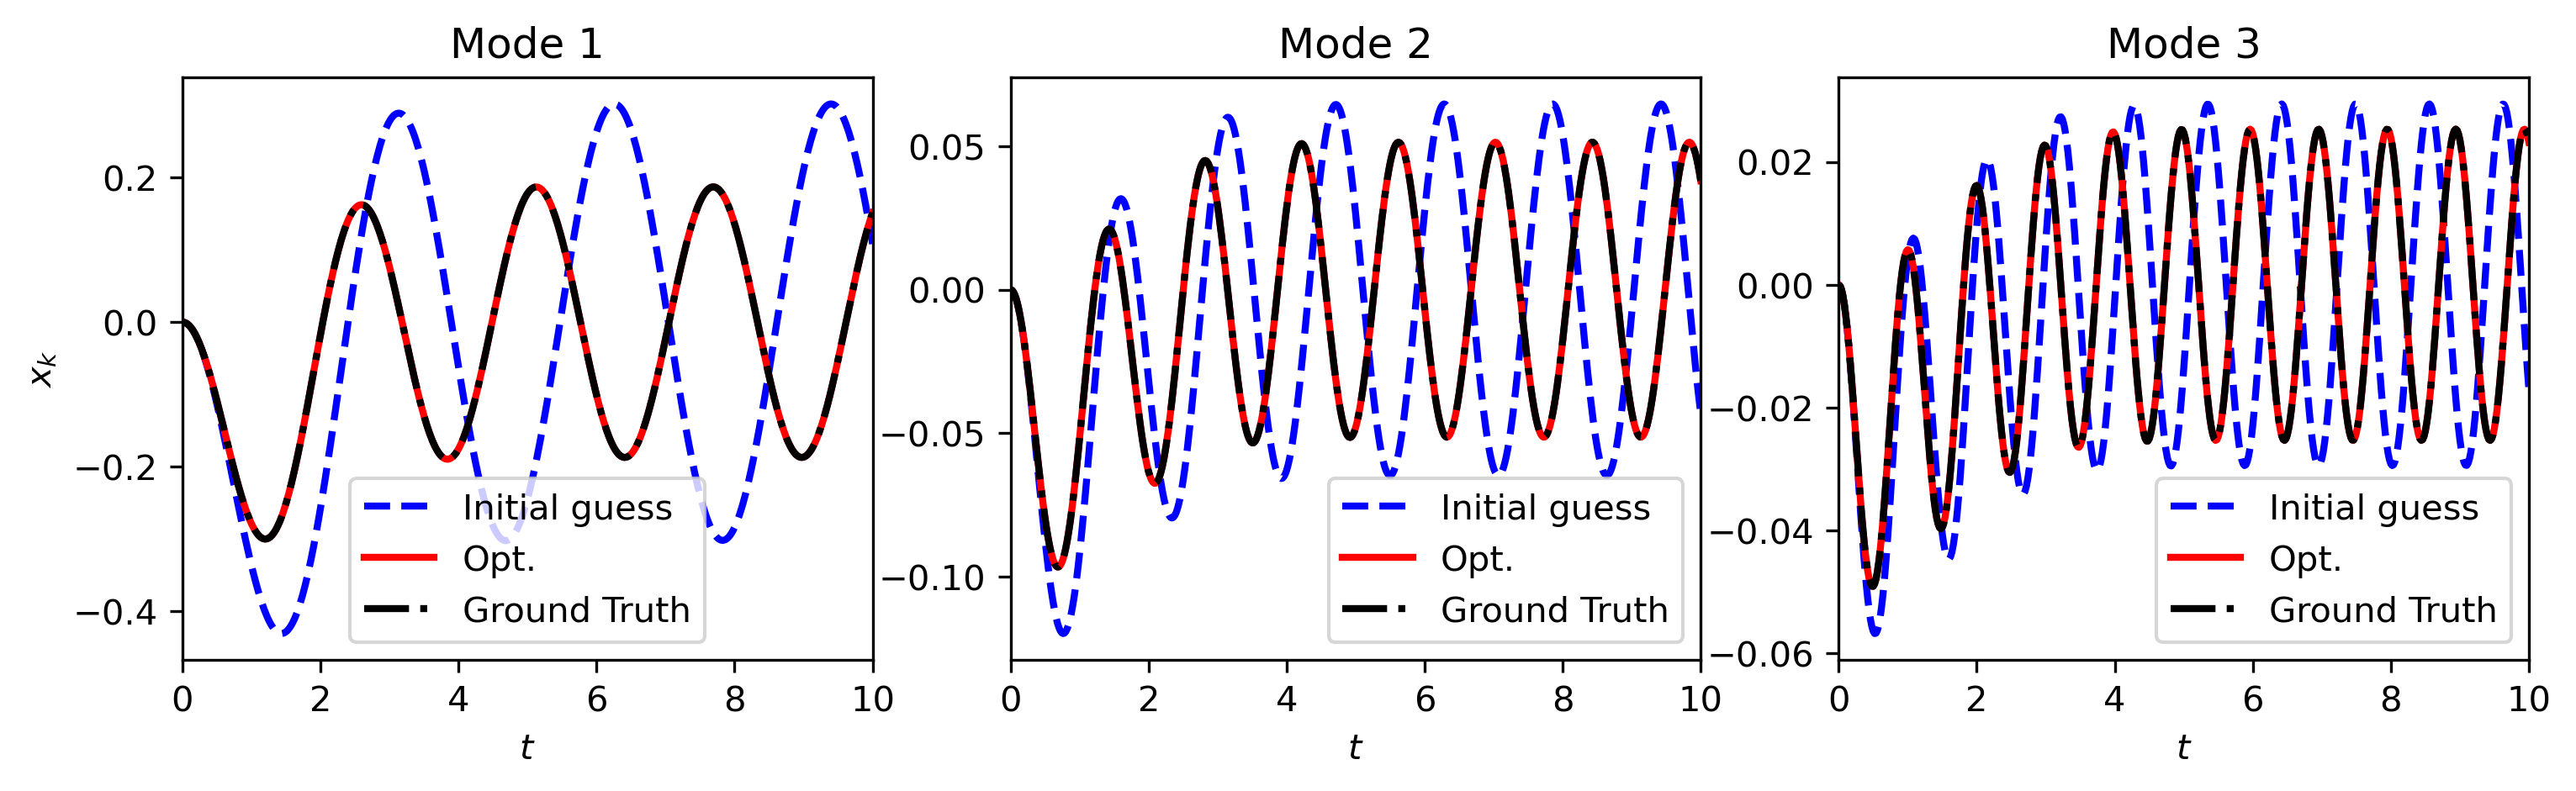

In [125]:
fig = plt.figure(figsize=(12,3), dpi=300)

for id_mode in range(3):
    plt.subplot(1,3,id_mode+1)

    obj0 = solver.eval_obj(p0)
    x0 = solver.x[:,id_mode].copy()

    p_opt = opt_res.x
    obj_opt = solver.eval_obj(p_opt)
    x_opt = solver.x[:,id_mode].copy()

    plt.plot(t, x0, label = "Initial guess", ls = "dashed", c = "b", lw = 2)
    plt.plot(t, x_opt, label = "Opt.", c = "r", lw = 2)
    plt.plot(t, q[:, id_mode], label = "Ground Truth", c="k", ls = "dashdot", lw = 2)

    plt.legend()
    plt.xlim(0, 10)
    # plt.ylim(-0.5, 0.5)
    plt.xlabel("$t$")
    if id_mode==0:
        plt.ylabel("$x_k$")
    plt.title("Mode {:d}".format(id_mode+1))

## **Real slushing dataset**

In [53]:
integrator = Integrator()
t = np.linspace(0.0, 40.0, 2001)
y0 = np.zeros(6)
q, q_func = integrator.solve(y0, t, args=(alpha2, alpha3, theta, d2theta, LFR))

In [54]:
LFRt = LFR(t)
M_kt = integrator.M_k(LFRt)
L_kt = integrator.L_k(LFRt)
omega_kt = alpha3(t) / L_kt

In [55]:
deg = 0
p = np.polyfit(LFRt, omega_kt.T, deg = deg)
np.flip(p.T, axis = 1)

array([[ 7.58364659],
       [20.19253821],
       [31.95533866]])

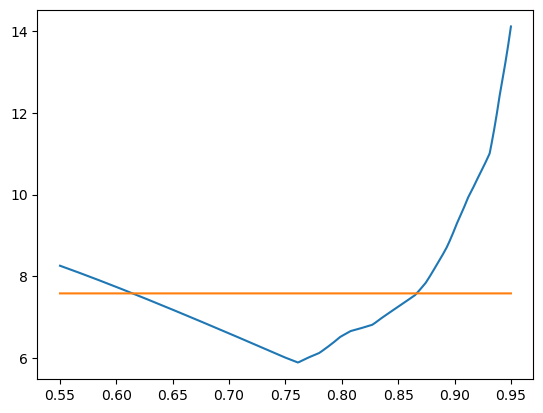

In [56]:
omega_kt_fit = p.T @ np.array([LFRt**k for k in np.arange(deg, -1, -1)])
plt.plot(LFRt,     omega_kt[0, :])
plt.plot(LFRt, omega_kt_fit[0, :])

In [60]:
solver_slosh = Adjoint(nmodes=3,Np=2,weight=np.array([10.0, 0.0, 0.0]),corrweight=np.array([0.0, 0.0, 0.0]),
                       y0=np.zeros(6),t=t,
                       alpha2=alpha2, alpha3=alpha3, theta=0.0, LFRt=LFR,
                       q=q, q_func=q_func)

p0 = np.array([ 1.770e+01,0.0 , 2.000e+01,0.0,  3.000e+01,0.0])

In [61]:
p0

array([17.7,  0. , 20. ,  0. , 30. ,  0. ])

In [62]:
solver_slosh.eval_obj(p0)

0.5425765091518637

In [63]:
from scipy.optimize import minimize

opt_res = minimize(solver_slosh.eval_obj, x0=p0, jac = solver_slosh.eval_grad_)
print(opt_res)

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.09147658029435052
        x: [ 1.012e+01 -4.422e+00  2.000e+01  0.000e+00  3.000e+01
             0.000e+00]
      nit: 15
      jac: [ 9.916e-06  7.942e-06  0.000e+00  0.000e+00  0.000e+00
             0.000e+00]
 hess_inv: [[ 9.672e+01 -1.241e+02 ...  0.000e+00  0.000e+00]
            [-1.241e+02  1.599e+02 ...  0.000e+00  0.000e+00]
            ...
            [ 0.000e+00  0.000e+00 ...  1.000e+00  0.000e+00]
            [ 0.000e+00  0.000e+00 ...  0.000e+00  1.000e+00]]
     nfev: 33
     njev: 33


Text(0, 0.5, '$y$')

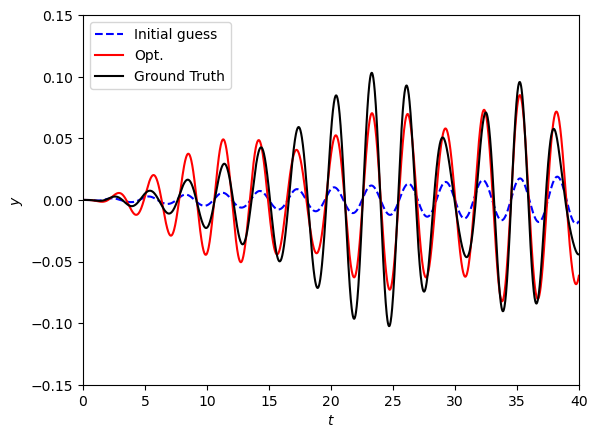

In [64]:
id_mode = 0

obj0 = solver_slosh.eval_obj(p0)
x0 = solver_slosh.x[:,id_mode].copy()

p_opt = opt_res.x
obj_opt = solver_slosh.eval_obj(p_opt)
x_opt = solver_slosh.x[:,id_mode].copy()

plt.plot(t, x0, label = "Initial guess", ls = "dashed", c = "b")
plt.plot(t, x_opt, label = "Opt.", c = "r")
plt.plot(t, q[:, id_mode], label = "Ground Truth", c="k")

plt.legend()
plt.xlim(0, 40)
plt.ylim(-0.15, 0.15)
plt.xlabel("$t$")
plt.ylabel("$y$")